In [1]:
!gdown 1GSi2bLndY8ESHMGLpGWYq9ohrAMKueyx
!gdown 1mmgMsvK4aAWDq6Nf9SCk-ap_9aYHxd_O

Downloading...
From: https://drive.google.com/uc?id=1GSi2bLndY8ESHMGLpGWYq9ohrAMKueyx
To: /content/eurusd-m5-2024-01to06-darwinex.csv
100% 1.90M/1.90M [00:00<00:00, 20.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mmgMsvK4aAWDq6Nf9SCk-ap_9aYHxd_O
To: /content/eurusd-m5-2023-06to12.csv
100% 1.00M/1.00M [00:00<00:00, 10.5MB/s]


In [2]:
!gdown 1YXaBx1rYdHgdy69QCd9lT6moJYr7_Vu4

Downloading...
From: https://drive.google.com/uc?id=1YXaBx1rYdHgdy69QCd9lT6moJYr7_Vu4
To: /content/eurusd_1992.csv
100% 473k/473k [00:00<00:00, 6.08MB/s]


## Modules and setup data columns

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [40]:
df = pd.read_csv("eurusd_1992.csv", sep="\t")

In [41]:
print(df.head(3))
print(list(df.columns))

       <DATE>  <OPEN>  <HIGH>   <LOW>  <CLOSE>  <TICKVOL>  <VOL>  <SPREAD>
0  1992.01.02  1.2841  1.2932  1.2735   1.2774       3271      0        50
1  1992.01.03  1.2771  1.2800  1.2630   1.2673       2421      0        50
2  1992.01.06  1.2678  1.2911  1.2676   1.2889       2591      0        50
['<DATE>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', '<VOL>', '<SPREAD>']


In [42]:
df = df.rename(columns={
    '<DATE>': 'Date',
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<CLOSE>': 'Close',
    '<TICKVOL>': 'TickVol',
    '<VOL>': 'Volume',
    '<SPREAD>': 'Spread'
});

In [43]:
# To keep it simple, keep track of date and OHLC
df = df.drop(columns=['Spread', 'TickVol', 'Volume'], errors='ignore')

In [44]:
#Ensure numeric rows are numeric
print(df.head(3))
numeric_cols = ['Open', 'High', 'Low', 'Close']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)

         Date    Open    High     Low   Close
0  1992.01.02  1.2841  1.2932  1.2735  1.2774
1  1992.01.03  1.2771  1.2800  1.2630  1.2673
2  1992.01.06  1.2678  1.2911  1.2676  1.2889


In [45]:
#Ensure Date column is date format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

In [46]:
feature_columns = ['Open', 'High', 'Low', 'Close']
df = df[feature_columns].dropna()
print(df.head(2))

              Open    High     Low   Close
Date                                      
1992-01-02  1.2841  1.2932  1.2735  1.2774
1992-01-03  1.2771  1.2800  1.2630  1.2673


## Setup target and lookahead period

In [47]:
#Predict next days closing price
lookahead = 1
df['Target'] = df['Close'].shift(-lookahead)
df.dropna(inplace=True)

In [48]:
print(df.head(3))

              Open    High     Low   Close  Target
Date                                              
1992-01-02  1.2841  1.2932  1.2735  1.2774  1.2673
1992-01-03  1.2771  1.2800  1.2630  1.2673  1.2889
1992-01-06  1.2678  1.2911  1.2676  1.2889  1.2973


## Time series split

In [49]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

In [50]:
print("Start of Training date", train_data.index[0], "End of Training date", train_data.index[-1])
print("Start of Test date", test_data.index[0], "End of Test date", test_data.index[-1])

Start of Training date 1992-01-02 00:00:00 End of Training date 2018-05-21 00:00:00
Start of Test date 2018-05-22 00:00:00 End of Test date 2024-12-30 00:00:00


## Feature Scaling

In [52]:
print(train_data.head(3))

              Open    High     Low   Close  Target
Date                                              
1992-01-02  1.2841  1.2932  1.2735  1.2774  1.2673
1992-01-03  1.2771  1.2800  1.2630  1.2673  1.2889
1992-01-06  1.2678  1.2911  1.2676  1.2889  1.2973


In [53]:
scaler = StandardScaler()
price_columns = ['Close', 'High', 'Low', 'Open']
train_scaled = scaler.fit_transform(train_data[price_columns])
test_scaled = scaler.transform(test_data[price_columns])

In [104]:
target_scaler = StandardScaler()
train_target_scaled = target_scaler.fit_transform(train_data[['Target']])[:, 0]
test_target_scaled = target_scaler.transform(test_data[['Target']])[:, 0]

## Setup Sequence

In [63]:
def create_seq(data, targets, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        # For example: Seq length 4 -> Days 0 to 3 predicts Day 4's closing price
        # Target is defined as next day's closing price, hence target[day 3] -> day 4's close price
        # Hence data[i-seq_length:i] -> days 0 to 3, targets[i-1] -> day 4's close price
        X.append(data[i-seq_length:i])
        y.append(targets[i-1])
    return np.array(X), np.array(y)

In [120]:
seq_length = 1
X_train_seq, Y_train_seq = create_seq(train_scaled, train_target_scaled, seq_length)
X_test_seq, Y_test_seq = create_seq(test_scaled, test_target_scaled, seq_length)

In [121]:
print("X_train_seq:", X_train_seq.shape)
print("Y_train_seq:", Y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape)
print("Y_test_seq:", Y_test_seq.shape)


X_train_seq: (6862, 1, 4)
Y_train_seq: (6862,)
X_test_seq: (1715, 1, 4)
Y_test_seq: (1715,)


## PyTorch Dataset

In [122]:
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_seq, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [123]:
for i in train_dataloader:
  print(i[0].shape, i[1].shape)
  break

torch.Size([32, 1, 4]) torch.Size([32])


## Setup FF neural network model

In [124]:
class FeedForwardNN(nn.Module):
  def __init__(self, seq_length, num_features):
    super(FeedForwardNN, self).__init__()
    input_dim = seq_length * num_features
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )
  def forward(self, x):
    return self.layers(x).squeeze(-1)

# model = FeedForwardNN(seq_length, len(price_columns))
# print(model(torch.randn(32, seq_length, len(price_columns))).shape)

In [125]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [144]:
learning_rate = 1e-5
model = FeedForwardNN(seq_length, len(price_columns))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-50)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [145]:
num_epochs = 100
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

train_losses = []
val_losses = []
best_model_state = None
for i in range(num_epochs):
  model.train()
  closs = 0
  for input, output in train_dataloader:
    input = input.to(device)
    output = output.to(device)
    optimizer.zero_grad()
    prediction = model(input)
    loss = criterion(prediction, output)
    loss.backward()
    optimizer.step()
    #train_losses.append(loss.item())
    closs += loss.item() * input.size(0)
  closs /= len(train_dataloader.dataset)
  train_losses.append(closs)

  model.eval()
  closs = 0.0
  with torch.no_grad():
      for input, output in test_dataloader:
          input = input.to(device)
          output = output.to(device)
          y_pred = model(input)
          loss = criterion(y_pred, output)
          closs += loss.item() * input.size(0)
  closs = closs / len(test_dataloader.dataset)
  val_losses.append(closs)

  scheduler.step(closs)

  print(f"Epoch {i+1}/{num_epochs} - Train Loss: {train_losses[-1]:.6f} - Val Loss: {val_losses[-1]:.6f}")
  if closs < best_val_loss:
    best_val_loss = closs
    epochs_no_improve = 0
    best_model_state = model.state_dict()
  else:
    epochs_no_improve += 1

  if epochs_no_improve == patience:
    print("Early stopping triggered")
    break




Epoch 1/100 - Train Loss: 1.000152 - Val Loss: 0.656751
Epoch 2/100 - Train Loss: 0.719556 - Val Loss: 0.473057
Epoch 3/100 - Train Loss: 0.505863 - Val Loss: 0.334172
Epoch 4/100 - Train Loss: 0.345851 - Val Loss: 0.228940
Epoch 5/100 - Train Loss: 0.233405 - Val Loss: 0.149642
Epoch 6/100 - Train Loss: 0.153985 - Val Loss: 0.091175
Epoch 7/100 - Train Loss: 0.097830 - Val Loss: 0.050231
Epoch 8/100 - Train Loss: 0.059744 - Val Loss: 0.024940
Epoch 9/100 - Train Loss: 0.035830 - Val Loss: 0.011672
Epoch 10/100 - Train Loss: 0.022023 - Val Loss: 0.005763
Epoch 11/100 - Train Loss: 0.013956 - Val Loss: 0.003429
Epoch 12/100 - Train Loss: 0.009283 - Val Loss: 0.002424
Epoch 13/100 - Train Loss: 0.006596 - Val Loss: 0.001933
Epoch 14/100 - Train Loss: 0.005128 - Val Loss: 0.001780
Epoch 15/100 - Train Loss: 0.004358 - Val Loss: 0.001675
Epoch 16/100 - Train Loss: 0.003949 - Val Loss: 0.001606
Epoch 17/100 - Train Loss: 0.003724 - Val Loss: 0.001505
Epoch 18/100 - Train Loss: 0.003592 - Va

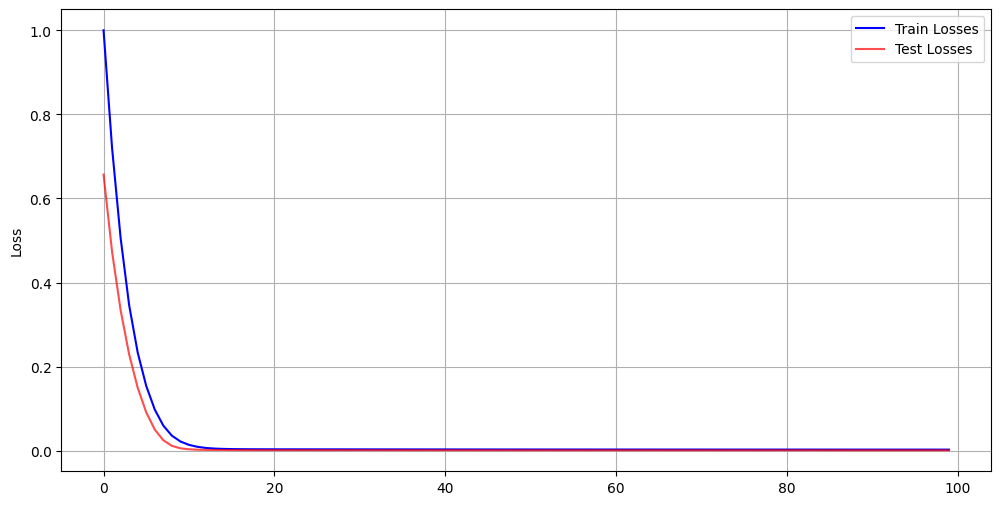

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Losses', color='blue')
plt.plot(val_losses, label='Test Losses', color='red', alpha=0.7)
#plt.title('Predicted vs Actual Future Price')
#plt.xlabel('Test Sample Index')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

## Predict and Plot

In [148]:
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for input, output in test_dataloader:
        input = input.to(device)
        output = output.to(device)
        y_pred = model(input)
        all_preds.extend(y_pred.cpu().numpy())
        all_actuals.extend(output.cpu().numpy())

mse = mean_squared_error(all_actuals, all_preds)
mae = mean_absolute_error(all_actuals, all_preds)
print("\nTest Set Performance:")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")



Test Set Performance:
MSE: 0.001
MAE: 0.025


In [149]:
all_preds_scaled = np.array(all_preds)
all_actuals_scaled = np.array(all_actuals)

all_preds = target_scaler.inverse_transform(all_preds_scaled.reshape(-1, 1)).flatten()
all_actuals = target_scaler.inverse_transform(all_actuals_scaled.reshape(-1, 1)).flatten()


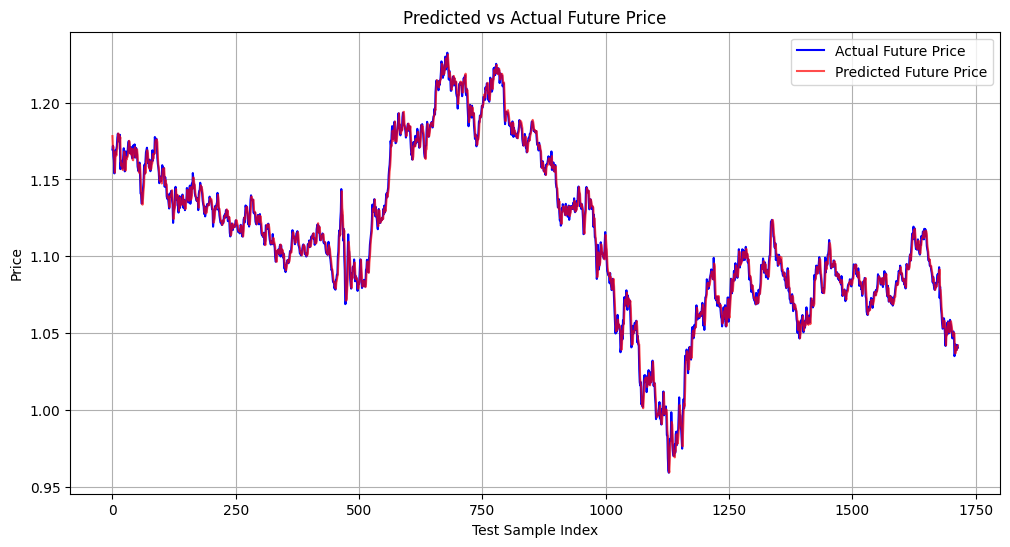

In [150]:
plt.figure(figsize=(12, 6))
plt.plot(all_actuals, label='Actual Future Price', color='blue')
plt.plot(all_preds, label='Predicted Future Price', color='red', alpha=0.7)
plt.title('Predicted vs Actual Future Price')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Simple Moving Average

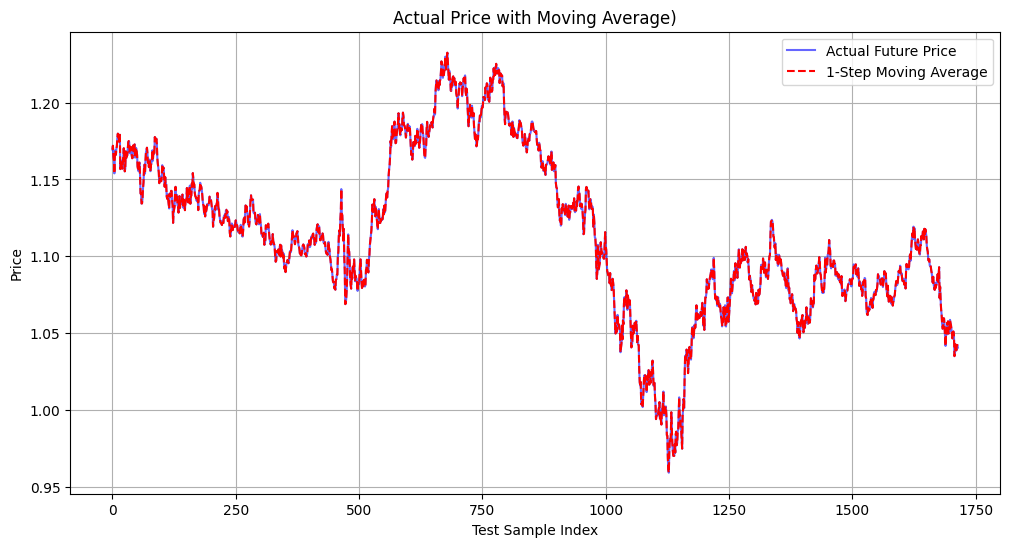

In [161]:
# Define moving average window
window_size = 1

# Compute Simple Moving Average (SMA) of actual prices
sma_actuals = pd.Series(all_actuals).rolling(window=window_size).mean()

# Plot actual prices, predicted prices, and the moving average
plt.figure(figsize=(12, 6))
plt.plot(all_actuals, label='Actual Future Price', color='blue', alpha=0.6)
plt.plot(sma_actuals, label=f'{window_size}-Step Moving Average', color='red', linestyle='dashed')

plt.title('Actual Price with Moving Average)')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()


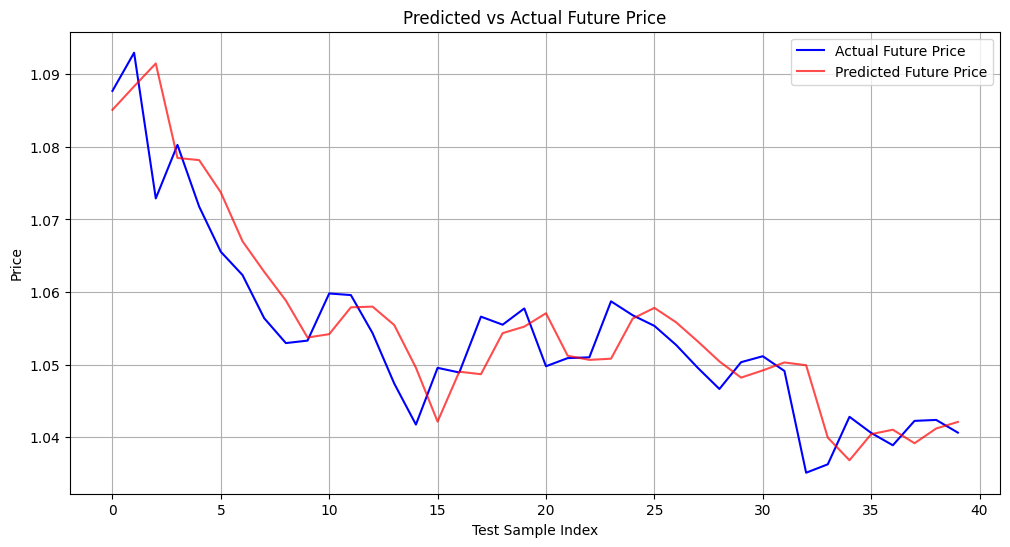

In [162]:
plt.figure(figsize=(12, 6))
plt.plot(all_actuals[-40:], label='Actual Future Price', color='blue')
plt.plot(all_preds[-40:], label='Predicted Future Price', color='red', alpha=0.7)
plt.title('Predicted vs Actual Future Price')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()